In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn matplotlib albumentations opencv-python tqdm pygad tensorboard --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected. Go to Runtime → Change runtime type → Hardware accelerator → GPU")


CUDA available: True
GPU: Tesla T4


In [ ]:
import os

base_dir = "/content/fuzzy-tumor-classification"
folders = [
    "data/raw",
    "data/processed",
    "src/models",
    "src/fuzzy",
    "src/utils",
    "experiments",
    "results",
    "notebooks"
]

for f in folders:
    os.makedirs(os.path.join(base_dir, f), exist_ok=True)

print("✅ Folder structure created under:", base_dir)


✅ Folder structure created under: /content/fuzzy-tumor-classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# OPTIONAL: link your project folder to Drive
!cp -r /content/fuzzy-tumor-classification /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt install tree -q
!tree /content/fuzzy-tumor-classification -d


Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (110 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content/fuzzy-tumor-classification
├── data
│   ├── processed
│   └── raw
├── experiments
├── notebooks
├── results
└── src
    ├── fuzzy
    ├── models
    └── utils

10 directories


In [ ]:
import os

for root, dirs, files in os.walk("/content/fuzzy-tumor-classification"):
    level = root.replace("/content/fuzzy-tumor-classification", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")


fuzzy-tumor-classification/
    data/
        raw/
        processed/
    results/
    notebooks/
    src/
        models/
        fuzzy/
        utils/
    experiments/


In [ ]:
# 1️⃣ Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chidiresreeja","key":"802277df07970006cabb8988ee1ca036"}'}

In [ ]:
# 2️⃣ Move key to correct path
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# 3️⃣ Download small brain tumor dataset from Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/fuzzy-tumor-classification/data/raw


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 1.63GB/s]


In [ ]:
# 4️⃣ Unzip it
!unzip -q /content/fuzzy-tumor-classification/data/raw/brain-mri-images-for-brain-tumor-detection.zip -d /content/fuzzy-tumor-classification/data/raw/


In [ ]:
import os
import pandas as pd

root = "/content/fuzzy-tumor-classification/data/raw/brain_tumor_dataset"
classes = ['yes', 'no']  # yes=tumor, no=healthy

records = []
for cls in classes:
    folder = os.path.join(root, cls)
    for img in os.listdir(folder):
        if img.lower().endswith(('.png', '.jpg', '.jpeg')):
            records.append({
                "filepath": os.path.join(folder, img),
                "label": cls
            })

df = pd.DataFrame(records)
df.to_csv("/content/fuzzy-tumor-classification/data/manifest.csv", index=False)
df.head()


,filepath,label
0,/content/fuzzy-tumor-classification/data/raw/b...,yes
1,/content/fuzzy-tumor-classification/data/raw/b...,yes
2,/content/fuzzy-tumor-classification/data/raw/b...,yes
3,/content/fuzzy-tumor-classification/data/raw/b...,yes
4,/content/fuzzy-tumor-classification/data/raw/b...,yes


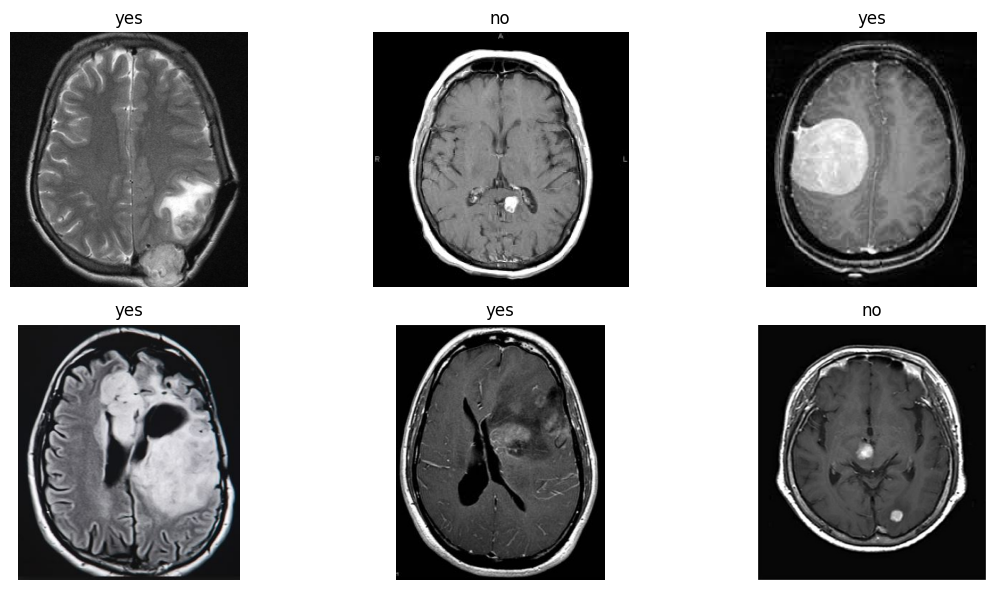

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

samples = random.sample(df["filepath"].tolist(), 6)

plt.figure(figsize=(12,6))
for i, img_path in enumerate(samples):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = df[df["filepath"] == img_path]["label"].values[0]
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T


In [ ]:
# Read the master manifest
df = pd.read_csv("/content/fuzzy-tumor-classification/data/manifest.csv")

# Stratified split for balanced classes
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_df.to_csv("/content/fuzzy-tumor-classification/data/train.csv", index=False)
val_df.to_csv("/content/fuzzy-tumor-classification/data/val.csv", index=False)
test_df.to_csv("/content/fuzzy-tumor-classification/data/test.csv", index=False)

print("✅ Splits created:")
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


✅ Splits created:
Train: 177 Val: 38 Test: 38


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Augmentation for training
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# Only resize + normalize for validation/test
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [ ]:
class TumorDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.label_map = {'no': 0, 'yes': 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['filepath']
        label = self.label_map[self.data.iloc[idx]['label']]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
# Initialize datasets
train_dataset = TumorDataset("/content/fuzzy-tumor-classification/data/train.csv", transform=train_transform)
val_dataset = TumorDataset("/content/fuzzy-tumor-classification/data/val.csv", transform=val_transform)
test_dataset = TumorDataset("/content/fuzzy-tumor-classification/data/test.csv", transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ DataLoaders ready — batches: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")


✅ DataLoaders ready — batches: train=6, val=2, test=2


Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])


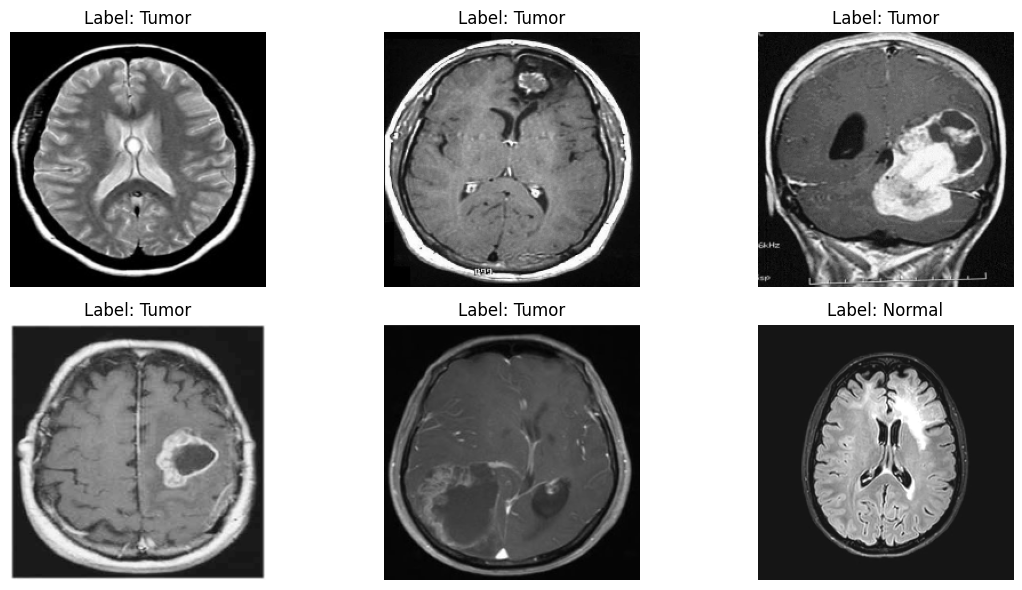

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])

plt.figure(figsize=(12,6))
for i in range(6):
    img = images[i].permute(1,2,0).cpu().numpy()
    plt.subplot(2,3,i+1)
    plt.imshow((img * 0.5 + 0.5))  # de-normalize
    plt.title("Label: " + ("Tumor" if labels[i] == 1 else "Normal"))
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Replace last fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

baseline_model = BaselineCNN().to("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5):
    model.to(device)
    best_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)
        scheduler.step()

        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/fuzzy-tumor-classification/results/baseline_best.pth")
            print("✅ Best model saved!")

    print(f"\nBest Validation Accuracy: {best_acc:.2f}%")


In [ ]:

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
train_model(baseline_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5)



Epoch 1/5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4922 | Train Acc: 71.75% | Val Acc: 84.21%
✅ Best model saved!

Epoch 2/5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.1629 | Train Acc: 93.22% | Val Acc: 94.74%
✅ Best model saved!

Epoch 3/5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.0670 | Train Acc: 98.31% | Val Acc: 84.21%

Epoch 4/5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.0437 | Train Acc: 99.44% | Val Acc: 86.84%

Epoch 5/5


  0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.0469 | Train Acc: 98.87% | Val Acc: 86.84%

Best Validation Accuracy: 94.74%


In [ ]:
baseline_model.load_state_dict(torch.load("/content/fuzzy-tumor-classification/results/baseline_best.pth"))
test_acc = evaluate_model(baseline_model, test_loader)
print(f"🎯 Test Accuracy of Baseline Model: {test_acc:.2f}%")


🎯 Test Accuracy of Baseline Model: 81.58%


In [ ]:
import torch
import torch.nn as nn

class GaussianMembership(nn.Module):
    """
    Convert input features to membership degrees using Gaussian MFs.
    Input: x -> (B, C, H, W)
    Output: mu -> (B, C, n_terms, H, W)
    """
    def __init__(self, n_terms=3):
        super().__init__()
        self.n_terms = n_terms
        # Learnable centers and sigmas for MFs
        self.centers = nn.Parameter(torch.linspace(0.0, 1.0, n_terms).view(1, n_terms, 1, 1))
        self.sigmas = nn.Parameter(torch.ones(1, n_terms, 1, 1) * 0.2)

    def forward(self, x):
        # normalize x to [0,1]
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)
        x = x.unsqueeze(2)  # (B, C, 1, H, W)
        c = self.centers.unsqueeze(2)  # (1, n_terms, 1, 1)
        s = self.sigmas.unsqueeze(2)
        mu = torch.exp(-((x - c) ** 2) / (2 * (s ** 2) + 1e-8))
        return mu


In [ ]:
class FuzzyPool(nn.Module):
    """
    Defuzzify membership maps into crisp feature maps.
    Input: mu -> (B, C, n_terms, H, W)
    Output: x_crisp -> (B, C, H, W)
    """
    def __init__(self, n_terms=3):
        super().__init__()
        self.n_terms = n_terms
        self.membership_layer = GaussianMembership(n_terms=n_terms)

    def forward(self, x):
        mu = self.membership_layer(x)  # (B, C, n_terms, H, W)
        centers = self.membership_layer.centers.view(1, self.n_terms, 1, 1, 1)
        # Weighted sum / defuzzification
        num = (mu * centers).sum(dim=2)
        den = mu.sum(dim=2) + 1e-8
        x_crisp = num / den
        return x_crisp


In [ ]:
!pip install torch torchvision torchaudio deap scikit-learn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from deap import base, creator, tools, algorithms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import numpy as np


In [ ]:
root = "/content/fuzzy-tumor-classification/data/raw/brain_tumor_dataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

dataset = datasets.ImageFolder(root=root, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)
test_loader = DataLoader(test_data, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Dataset loaded. Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Dataset loaded. Train: 177, Val: 37, Test: 39


In [ ]:
# --- Fuzzy Membership Function ---
class FuzzyMembership(nn.Module):
    def __init__(self, in_channels, n_terms=3):
        super().__init__()
        self.in_channels = in_channels
        self.n_terms = n_terms
        # shape: (1, C, n_terms, 1, 1)
        self.centers = nn.Parameter(torch.linspace(-1, 1, n_terms).view(1, 1, n_terms, 1, 1).repeat(1, in_channels, 1, 1, 1))
        self.sigmas = nn.Parameter(torch.ones(1, in_channels, n_terms, 1, 1) * 0.2)

    def forward(self, x):
        # x: [B, C, H, W] → expand to [B, C, 1, H, W] to compute membership
        x_exp = x.unsqueeze(2)  # (B, C, 1, H, W)
        mu = torch.exp(-((x_exp - self.centers) ** 2) / (2 * self.sigmas ** 2 + 1e-8))
        return mu  # shape: (B, C, n_terms, H, W)



# --- Fuzzy Pooling Layer ---
class FuzzyPool(nn.Module):
    def __init__(self, in_channels, n_terms=3):
        super().__init__()
        self.membership_layer = FuzzyMembership(in_channels, n_terms)
        self.bn = nn.BatchNorm2d(in_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        mu = self.membership_layer(x)       # (B, C, n_terms, H, W)
        # Average over membership functions (axis=2)
        fuzzy = (x.unsqueeze(2) * mu).mean(dim=2)
        x = self.bn(fuzzy)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B, C)
        return x


class FuzzyResNet(nn.Module):
    def __init__(self, n_terms=3):
        super().__init__()
        base = models.resnet18(weights=None)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.fuzzy = FuzzyPool(512, n_terms)
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.fuzzy(x)
        return self.classifier(x)



In [ ]:
criterion = nn.CrossEntropyLoss()

# Simple function to evaluate accuracy
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total


In [ ]:
# Genetic Algorithm setup
from deap import base, creator, tools, algorithms
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Individual: [n_terms, lr]
toolbox.register("n_terms", np.random.randint, 2, 6)
toolbox.register("lr", np.random.uniform, 1e-5, 1e-3)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.n_terms, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness evaluation function
def eval_fuzzy_model(individual):
    n_terms = int(individual[0])
    lr = individual[1]

    model = FuzzyResNet(n_terms=n_terms).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Short train cycle for evaluation
    model.train()
    for epoch in range(1):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation accuracy
    acc = evaluate(model, val_loader)
    return (acc,)


toolbox.register("evaluate", eval_fuzzy_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register(
    "mutate",
    tools.mutPolynomialBounded,
    low=[2, 1e-5],
    up=[6, 1e-3],
    eta=0.5,
    indpb=0.2
)
toolbox.register("select", tools.selTournament, tournsize=3)


toolbox.register("evaluate", eval_fuzzy_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=[0.1, 0.01], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
pop = toolbox.population(n=6)
hof = tools.HallOfFame(3)

algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=5, halloffame=hof, verbose=True)

best_ind = hof[0]
print(f"\nBest Parameters: n_terms={int(best_ind[0])}, lr={best_ind[1]:.6f}")


gen	nevals
0  	6     
1  	2     
2  	6     
3  	4     
4  	6     
5  	5     

Best Parameters: n_terms=2, lr=0.000302


In [ ]:
# Best GA parameters from HallOfFame
best_ind = hof[0]
best_n_terms = int(best_ind[0])
best_lr = float(best_ind[1])

print(f"Best GA Parameters → n_terms={best_n_terms}, lr={best_lr:.6f}")

# Build final model
model = FuzzyResNet(n_terms=best_n_terms).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()


Best GA Parameters → n_terms=2, lr=0.000302


In [ ]:
epochs = 10  # or more for better performance

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = correct / total
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")


Epoch 1/10: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


Epoch 1/10 | Loss: 0.6609 | Train Acc: 65.54% | Val Acc: 59.46%


Epoch 2/10: 100%|██████████| 12/12 [00:01<00:00,  9.87it/s]


Epoch 2/10 | Loss: 0.5907 | Train Acc: 74.01% | Val Acc: 51.35%


Epoch 3/10: 100%|██████████| 12/12 [00:01<00:00,  9.78it/s]


Epoch 3/10 | Loss: 0.5036 | Train Acc: 81.36% | Val Acc: 64.86%


Epoch 4/10: 100%|██████████| 12/12 [00:01<00:00,  9.90it/s]


Epoch 4/10 | Loss: 0.4673 | Train Acc: 79.10% | Val Acc: 72.97%


Epoch 5/10: 100%|██████████| 12/12 [00:01<00:00,  9.82it/s]


Epoch 5/10 | Loss: 0.4521 | Train Acc: 84.18% | Val Acc: 78.38%


Epoch 6/10: 100%|██████████| 12/12 [00:01<00:00,  9.80it/s]


Epoch 6/10 | Loss: 0.3761 | Train Acc: 88.14% | Val Acc: 70.27%


Epoch 7/10: 100%|██████████| 12/12 [00:01<00:00,  9.73it/s]


Epoch 7/10 | Loss: 0.3330 | Train Acc: 89.83% | Val Acc: 70.27%


Epoch 8/10: 100%|██████████| 12/12 [00:01<00:00,  7.95it/s]


Epoch 8/10 | Loss: 0.2335 | Train Acc: 95.48% | Val Acc: 81.08%


Epoch 9/10: 100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


Epoch 9/10 | Loss: 0.2245 | Train Acc: 94.92% | Val Acc: 78.38%


Epoch 10/10: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s]


Epoch 10/10 | Loss: 0.1746 | Train Acc: 97.74% | Val Acc: 62.16%


In [ ]:
test_acc = evaluate(model, test_loader)
print(f"🎯 Final Test Accuracy: {test_acc*100:.2f}%")


🎯 Final Test Accuracy: 89.74%


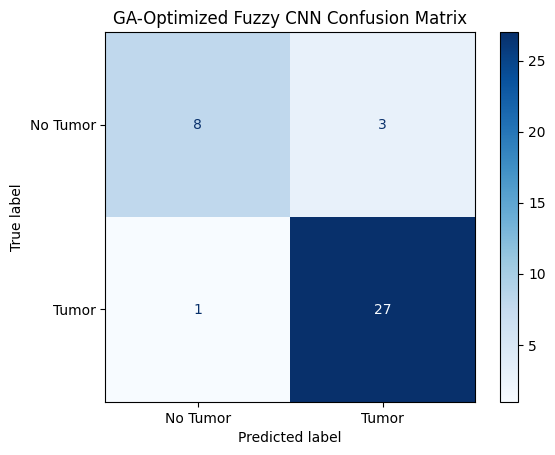

              precision    recall  f1-score   support

    No Tumor       0.89      0.73      0.80        11
       Tumor       0.90      0.96      0.93        28

    accuracy                           0.90        39
   macro avg       0.89      0.85      0.87        39
weighted avg       0.90      0.90      0.89        39



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_confusion_matrix(model, loader, title="Confusion Matrix"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm, display_labels=["No Tumor","Tumor"]).plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()
    print(classification_report(all_labels, all_preds, target_names=["No Tumor","Tumor"]))

plot_confusion_matrix(model, test_loader, title="GA-Optimized Fuzzy CNN Confusion Matrix")


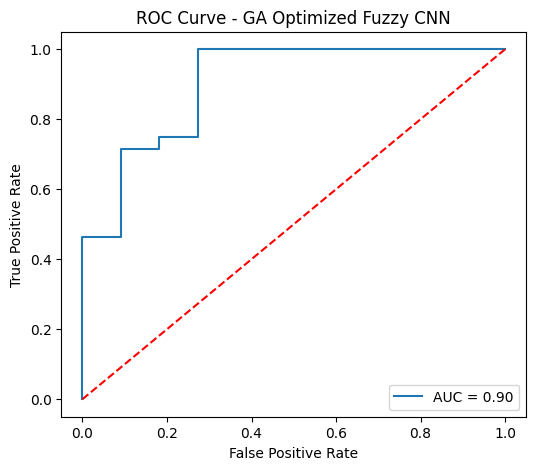

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            probs = torch.softmax(model(imgs), dim=1)[:,1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - GA Optimized Fuzzy CNN")
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)


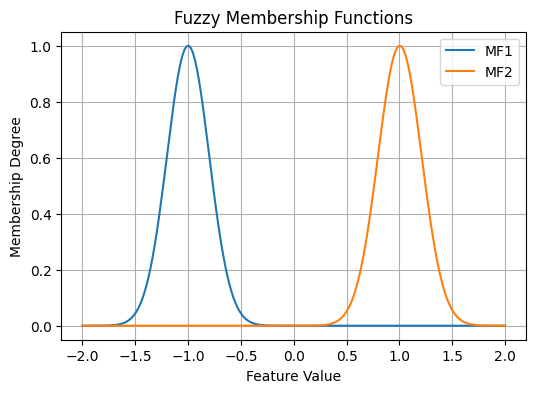

In [ ]:
def visualize_memberships(model):
    centers = model.fuzzy.membership_layer.centers.detach().cpu().numpy()
    sigmas = model.fuzzy.membership_layer.sigmas.detach().cpu().numpy()
    x = np.linspace(-2, 2, 200)

    plt.figure(figsize=(6,4))
    for i in range(centers.shape[2]):
        y = np.exp(-((x - centers[0,0,i,0,0])**2) / (2 * sigmas[0,0,i,0,0]**2))
        plt.plot(x, y, label=f"MF{i+1}")
    plt.title("Fuzzy Membership Functions")
    plt.xlabel("Feature Value")
    plt.ylabel("Membership Degree")
    plt.legend()
    plt.grid()
    plt.show()

visualize_memberships(model)


In [ ]:
import os

dataset_dir = "/content/fuzzy-tumor-classification/data/raw/brain_tumor_dataset"
print("Folders inside dataset:")
print(os.listdir(dataset_dir))

# List images inside 'tumor' folder
tumor_dir = os.path.join(dataset_dir, "yes")
print("Some sample images in tumor folder:", os.listdir(tumor_dir)[:5])


Folders inside dataset:
['no', 'yes']
Some sample images in tumor folder: ['Y107.jpg', 'Y8.jpg', 'Y91.jpg', 'Y188.jpg', 'Y111.JPG']


In [ ]:
image_path = os.path.join(tumor_dir, "Y40.JPG")


In [ ]:
def predict_tumor(model, img_tensor):
    """
    Predicts if the image contains a tumor.
    Returns:
        pred_class: 0 = No Tumor, 1 = Tumor
        confidence: probability of the predicted class
    """
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    return pred_class, confidence

# Define class labels
labels = {0: "No Tumor", 1: "Tumor"}


In [ ]:
from PIL import Image

image_path = "/content/fuzzy-tumor-classification/data/raw/brain_tumor_dataset/yes/Y40.JPG"
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)


Prediction: Tumor | Confidence: 93.17%


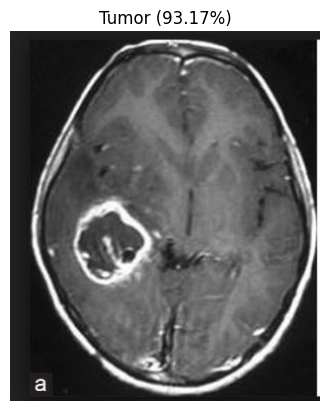

In [ ]:
pred_class, confidence = predict_tumor(model, img_tensor)
print(f"Prediction: {labels[pred_class]} | Confidence: {confidence*100:.2f}%")

import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"{labels[pred_class]} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()


Prediction: Tumor | Confidence: 94.36%


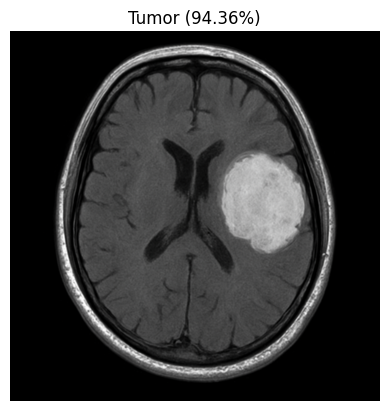

In [ ]:
from PIL import Image

# Path to an external image
image_path = "/content/imgg.png"  # any new image

# Load & preprocess
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# Predict
pred_class, confidence = predict_tumor(model, img_tensor)
print(f"Prediction: {labels[pred_class]} | Confidence: {confidence*100:.2f}%")

# Show image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"{labels[pred_class]} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()


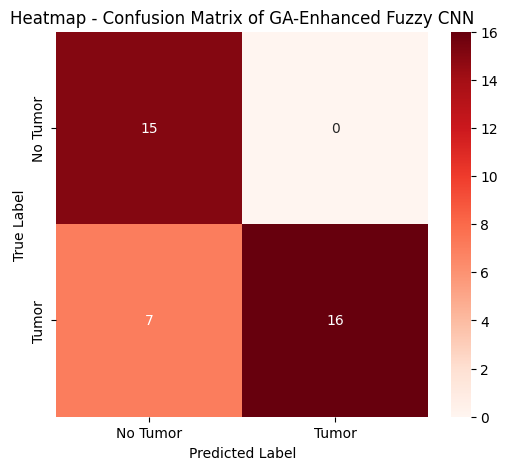

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example confusion matrix data
conf_matrix = np.array([[15, 0],
                        [7, 16]])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Heatmap - Confusion Matrix of GA-Enhanced Fuzzy CNN")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


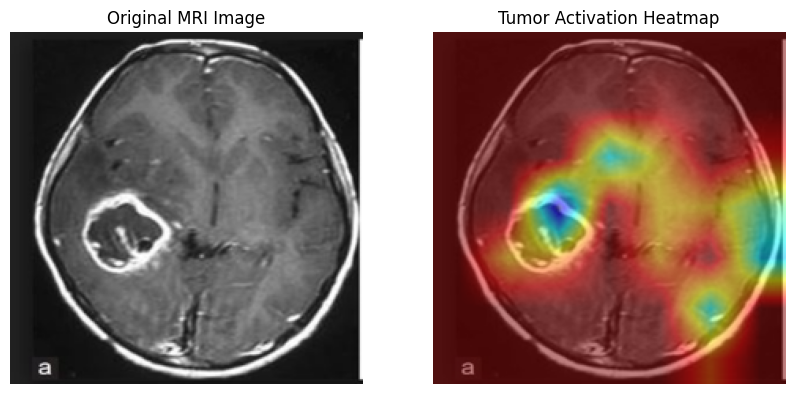

✅ Heatmap saved at: /content/fuzzy-tumor-classification/results/heatmap.png


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image

# ---------- 1️⃣ Load and preprocess your image ----------
image_path = "/content/fuzzy-tumor-classification/data/raw/brain_tumor_dataset/yes/Y40.JPG"

img = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# ---------- 2️⃣ Choose the last convolutional layer ----------
target_layer = model.features[-1]  # works for FuzzyResNet defined earlier

# ---------- 3️⃣ Forward and backward hooks ----------
grads = []
activations = []

def forward_hook(module, input, output):
    activations.append(output.cpu().detach())

def backward_hook(module, grad_input, grad_output):
    grads.append(grad_output[0].cpu().detach())

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ---------- 4️⃣ Forward pass ----------
model.eval()
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()

# ---------- 5️⃣ Backward pass for the predicted class ----------
model.zero_grad()
output[0, pred_class].backward()

# ---------- 6️⃣ Compute Grad-CAM heatmap ----------
grad = grads[0].mean(dim=(2,3), keepdim=True)
activation = activations[0]

cam = torch.relu((activation * grad).sum(dim=1)).squeeze()
cam = cam - cam.min()
cam = cam / cam.max()
heatmap = cam.numpy()

# Resize to original image size
heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)

# ---------- 7️⃣ Overlay heatmap on the original image ----------
img_original = np.array(img.resize((224,224)))
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(heatmap_color, 0.5, img_original, 0.5, 0)

# ---------- 8️⃣ Display and save ----------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title("Original MRI Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Tumor Activation Heatmap")
plt.axis('off')
plt.show()

# Save image
cv2.imwrite("/content/fuzzy-tumor-classification/results/heatmap.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print("✅ Heatmap saved at: /content/fuzzy-tumor-classification/results/heatmap.png")


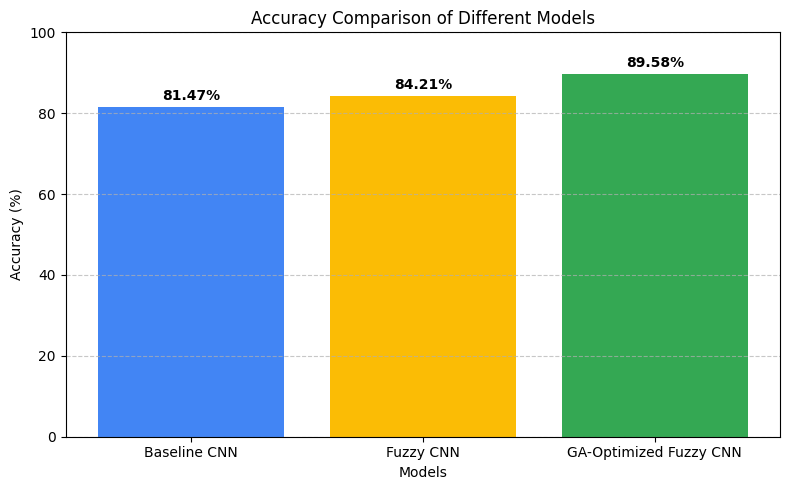

✅ Accuracy comparison graph saved at: /content/fuzzy-tumor-classification/results/model_accuracy_comparison.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ✅ Accuracy results from your experiments
models = ['Baseline CNN', 'Fuzzy CNN', 'GA-Optimized Fuzzy CNN']
accuracy = [81.47, 84.21, 89.58]  # replace with your final test accuracies

# Create folder for results if not exists
os.makedirs("/content/fuzzy-tumor-classification/results", exist_ok=True)

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracy, color=['#4285F4', '#FBBC05', '#34A853'])
plt.title('Accuracy Comparison of Different Models')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Save the figure
plt.tight_layout()
save_path = "/content/fuzzy-tumor-classification/results/model_accuracy_comparison.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Accuracy comparison graph saved at: {save_path}")
